In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
from SimPEG import Mesh, PF, Utils, Maps, DataMisfit, Directives, Inversion, InvProblem, Optimization, Regularization
from GeoToolkit.Mag import Simulator, MathUtils
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from discretize.utils import meshutils
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import shutil
# import pyvista as pv
from skimage import exposure
# pv.set_plot_theme('document')
# pv.rcParams['use_panel'] = False
from fatiando.gravmag import transform

C:\Users\DominiqueFournier\Documents\GIT\Fatiando\Fatiando\fatiando\vis\mpl.py:69: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "matplotlib.pyplot module directly. Some of the fatiando " +


# Data

First import the data and topography

In [3]:
wd = r"C:\Users\DominiqueFournier\Dropbox\Projects\Synthetic\Block_Gaussian_topo"
    
survey = Utils.io_utils.readUBCmagneticsObservations(wd + "\\Obs_loc_TMI.obs")[0]

rxLoc = survey.rxLoc
surveyId = survey.std
topo = np.loadtxt(wd + "\\Gaussian.topo", skiprows=1)

In [4]:
out = Simulator.dataGriddingWidget(np.c_[survey.rxLoc, survey.dobs], dataColumn=4)
display(out)

interactive(children=(FloatText(value=25.0, description='Grid (m):'), FloatText(value=200.0, description='Dist…

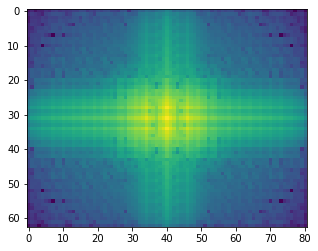

In [51]:
grid = out.result
pwer = np.fft.fftshift(abs(grid.gridFFT)**2.)
plt.figure()
plt.imshow(np.log10(pwer))





In [52]:
np.fft.fftshift(grid.Kx)[0,:]





array([-0.31028076, -0.30252374, -0.29476672, -0.2870097 , -0.27925268,
       -0.27149566, -0.26373864, -0.25598162, -0.2482246 , -0.24046759,
       -0.23271057, -0.22495355, -0.21719653, -0.20943951, -0.20168249,
       -0.19392547, -0.18616845, -0.17841143, -0.17065442, -0.1628974 ,
       -0.15514038, -0.14738336, -0.13962634, -0.13186932, -0.1241123 ,
       -0.11635528, -0.10859826, -0.10084125, -0.09308423, -0.08532721,
       -0.07757019, -0.06981317, -0.06205615, -0.05429913, -0.04654211,
       -0.03878509, -0.03102808, -0.02327106, -0.01551404, -0.00775702,
        0.        ,  0.00775702,  0.01551404,  0.02327106,  0.03102808,
        0.03878509,  0.04654211,  0.05429913,  0.06205615,  0.06981317,
        0.07757019,  0.08532721,  0.09308423,  0.10084125,  0.10859826,
        0.11635528,  0.1241123 ,  0.13186932,  0.13962634,  0.14738336,
        0.15514038,  0.1628974 ,  0.17065442,  0.17841143,  0.18616845,
        0.19392547,  0.20168249,  0.20943951,  0.21719653,  0.22

In [53]:
grid.dx



10.0

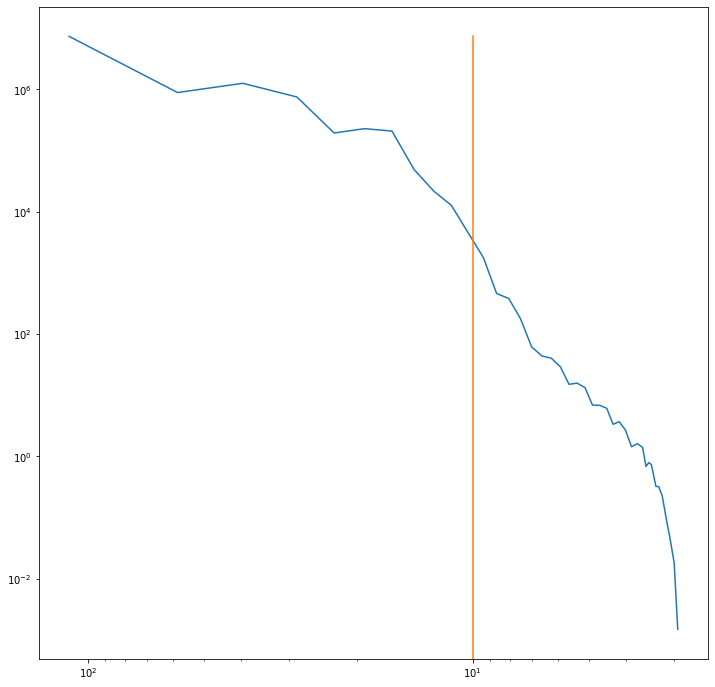

In [54]:


# Compute radial power spectra
axis = np.min(pwer.shape)

# Compute distance of all grid point from the center
X, Y = np.meshgrid(np.arange(-pwer.shape[1]/2, pwer.shape[1]/2), np.arange(-pwer.shape[0]/2, pwer.shape[0]/2))
dist = (X**2 + Y**2)**0.5

Kx_shift = np.fft.fftshift(grid.Kx)
Ky_shift = np.fft.fftshift(grid.Ky)
rad_pwr = []
wave = []
for ii in range(axis):

    ind = (dist>(ii-.5)) * (dist < (ii+.5))
    rad_pwr.append(np.mean(pwer[ind]))
    wave.append((np.mean(Kx_shift[ind]**2 + Ky_shift[ind]**2)**-0.5))

# Cutoff
rad_pwr =  np.hstack(rad_pwr)
wave = np.hstack(wave)
ind = rad_pwr > 1e-4
plt.figure(figsize=(12,12))
axs = plt.subplot()
axs.loglog(wave[ind], rad_pwr[ind])
axs.loglog([grid.dx, grid.dx], [0, rad_pwr[ind].max()])
axs.invert_xaxis()

In [46]:

wave[ind]



array([        inf, 86.10310764, 48.81587355, 34.67317324, 25.76659612,
       20.51292592, 17.28992008, 14.92843161, 13.16466209, 11.63297282,
       10.42694217,  9.52788291,  8.88298626,  8.35339291,  7.87764251,
        7.46973453,  6.8724598 ,  6.46131931,  6.0191231 ])

In [33]:
dist.max()




102.61578825892242

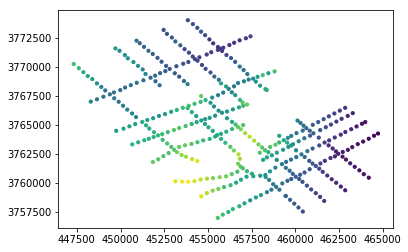

In [4]:
axs = plt.subplot()
axs.scatter(rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], 10, rxLoc[surveyId==1, 2])

# Plotting Fa before and after Latitude correction

(0.0, 1.0, 0.0, 1.0)

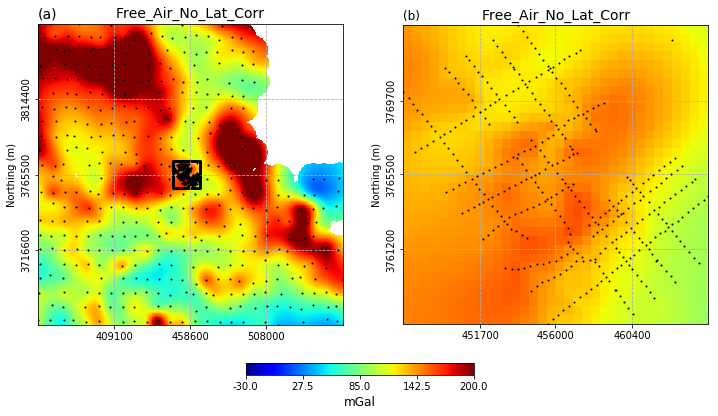

In [5]:
# surveyFull = Utils.io_utils.readUBCgravityObservations("Fa_777_No_Lat_Corr_ID.txt")

# rxLoc = surveyFull.rxLoc
# surveyId = surveyFull.std
local = np.r_[rxLoc[surveyId>0,:2].min(axis=0), rxLoc[surveyId>0,:2].max(axis=0)]
regio = np.r_[rxLoc[:,:2].min(axis=0), rxLoc[:,:2].max(axis=0)]

fig = plt.figure(figsize=(12,12))
vminData, vmaxData = -30, 200

ax1 = plt.subplot(1,2,1)

xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(regio[0], regio[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(regio[1], regio[3],5)[1:4].tolist()]

vminData, vmaxData = -30, 180
out = Simulator.plotDataHillside(
    rxLoc[:, 0], rxLoc[:, 1], surveyFull.dobs, 
    axs=ax1, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax1.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax1.add_collection(pc)
ax1.grid(True, linestyle='--')
ax1.set_xticks(xlabel)
ax1.set_xticklabels(xlabel)
ax1.set_yticks(ylabel)
ax1.set_yticklabels(ylabel, va='center', rotation=90)
ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
ax1.set_title('(a)', loc='left', size=14)
ax1.set_title("Free_Air_No_Lat_Corr", size=14)


ax2 = plt.subplot(1,2,2)

xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -30, 200
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], surveyFull.dobs[surveyId==1], 
    axs=ax2, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax2.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
#pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
#ax2.add_collection(pc)
ax2.grid(True, linestyle='--')
ax2.set_xticks(xlabel)
ax2.set_xticklabels(xlabel)
ax2.set_yticks(ylabel)
ax2.set_yticklabels(ylabel, va='center', rotation=90)
ax2.set_ylabel("Northing (m)", rotation=90)
ax2.set_aspect('equal')
ax2.set_title("Free_Air_No_Lat_Corr", size=14)
ax2.set_title('(b)', loc='left', size=12)

pos = ax1.get_position()
axbar = plt.axes([pos.x0+.24, pos.y0-0.06,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=12)
axbar.axis('off')

#plt.savefig("FA_376_777_No_LatCorr.png", dpi=300, bbox_inches='tight')

In [6]:
# # Load the geology
# import shapefile as shp  # Requires the pyshp package

# sf = shp.Reader("geo2cg\\geo2cg_UTM.shp")

# X, Y = [], []
# for shape in sf.shapeRecords():

#     for ii, part in enumerate(shape.shape.parts):

#         if ii != len(shape.shape.parts)-1:
#             x = [i[0] for i in shape.shape.points[shape.shape.parts[ii]:shape.shape.parts[ii+1]]]
#             y = [i[1] for i in shape.shape.points[shape.shape.parts[ii]:shape.shape.parts[ii+1]]]

#         else:
#             x = [i[0] for i in shape.shape.points[shape.shape.parts[ii]:]]
#             y = [i[1] for i in shape.shape.points[shape.shape.parts[ii]:]]

#         X.append(np.vstack(x))
#         Y.append(np.vstack(y))

# Figure 1
(a) Gravity and (b) topography over the regional survey. The local high-resolution survey and topography are shown in (c) and (d)

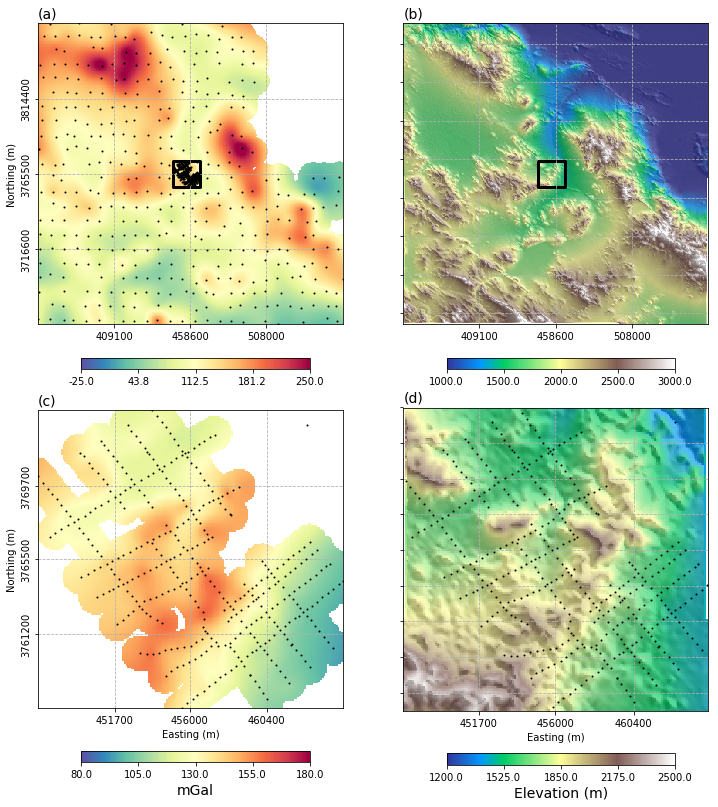

In [7]:

fig = plt.figure(figsize=(12,13))
ax1 = plt.subplot(2,2,1)

xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(regio[0], regio[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(regio[1], regio[3],5)[1:4].tolist()]
vminTopo, vmaxTopo = 1000, 3000
vminData, vmaxData = -25, 250
out = Simulator.plotDataHillside(
    rxLoc[:, 0], rxLoc[:, 1], surveyFull.dobs, 
    axs=ax1, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='Spectral_r', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax1.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax1.add_collection(pc)
ax1.grid(True, linestyle='--')
ax1.set_xticks(xlabel)
ax1.set_xticklabels(xlabel)
ax1.set_yticks(ylabel)
ax1.set_yticklabels(ylabel, va='center', rotation=90)
ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
ax1.set_title('(a)', loc='left', size=14)

pos = ax1.get_position()
axbar = plt.axes([pos.x0+.05, pos.y0-0.05,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
#cbar.set_label("mGal", size=14)
axbar.axis('off')

ax2 = plt.subplot(2,2,2)
ind = (topo[:, 0] > regio[0]) * (topo[:, 0] < regio[2]) * (topo[:, 1] > regio[1]) * (topo[:, 1] < regio[3])
out = Simulator.plotDataHillside(
    topo[ind, 0], topo[ind, 1], topo[ind, 2], 
    axs=ax2, fill=True,
    vmin=vminTopo, vmax=vmaxTopo, resolution=500,
    clabel=True, cmap='terrain', ve=10., alpha=8., alphaHS=0.3,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=False,
    scatterData=None, shapeFile=None)
ax2.set_xticks(xlabel)
ax2.set_xticklabels(xlabel)
ax2.set_aspect('equal')
ax2.grid(True, linestyle='--')
ax2.set_yticklabels([])
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax2.add_collection(pc)
ax2.set_title('(b)', loc='left', size=14)

pos = ax2.get_position()
axbar = plt.axes([pos.x0+.05, pos.y0-0.05,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminTopo,vmaxTopo,5))
#cbar.set_label("Elevation (m)", size=14)
axbar.axis('off')

ax3 = plt.subplot(2,2,3)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = 80, 180
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], surveyFull.dobs[surveyId==1], 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='Spectral_r', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(c)', loc='left', size=14)

pos = ax3.get_position()
axbar = plt.axes([pos.x0+.05, pos.y0-0.06,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')

ax4 = plt.subplot(2,2,4)
ind = (topo[:, 0] > local[0]) * (topo[:, 0] < local[2]) * (topo[:, 1] > local[1]) * (topo[:, 1] < local[3])
vminTopo = 1200
vmaxTopo = 2500
out = Simulator.plotDataHillside(
    topo[ind, 0], topo[ind, 1], topo[ind, 2], 
    axs=ax4, fill=True,
    vmin=vminTopo, vmax=vmaxTopo, resolution=100,
    clabel=True, cmap='terrain', ve=10., alpha=8., alphaHS=0.3,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=False,
    scatterData=None, shapeFile=None)
ax4.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax4.set_xticks(xlabel)
ax4.set_xticklabels(xlabel)
ax4.set_xlabel("Easting (m)", rotation=0)
ax4.set_aspect('equal')
ax4.set_yticklabels([])
ax4.grid(True, linestyle='--')
ax4.set_title('(d)', loc='left', size=14)

pos = ax4.get_position()
axbar = plt.axes([pos.x0+.05, pos.y0-0.06,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminTopo,vmaxTopo,5))
cbar.set_label("Elevation (m)", size=14)
axbar.axis('off')

#plt.savefig("Mahallat_Data_Topo_Quad_Tree_2.png", dpi=300, bbox_inches='tight')

# Build an QuadTree mesh 

In [5]:
from scipy.spatial import cKDTree
#cKDTree: This class provides an index into a set of k-dimensional 
#points which can be used to rapidly look up the nearest neighbors of any point.
core_cell_size = [90, 90]
padding_distance = [[5000, 5000], [5000, 5000], [5000, 0]]
octree_levels_topo = [0,0,0,12]
octree_levels_obs = [2]
octree_levels_padding = [2]
max_distance = 5000
depth_core = 5000

ind = (topo[:, 0] > local[0]) * (topo[:, 0] < local[2]) * (topo[:, 1] > local[1]) * (topo[:, 1] < local[3])


mesh2D_base = meshutils.mesh_builder_xyz(
    topo[ind, :2], core_cell_size,
    padding_distance=padding_distance,
    mesh_type='TREE',
    depth_core=depth_core
    )

mesh2D_base.refine(12, finalize=True)

print(ind)

[False False False ... False False False]


In [6]:
mesh2D_base.h_gridded[:,0].min()

90.0

In [6]:
# linear and MC interp
# tri2D = Delaunay(topo[:, :2])
# F = LinearNDInterpolator(tri2D, topo[:, 2],2)


z_lin_base = F_lin(mesh2D_base.gridCC)

# for i in [z_lin_base[:]]: 
#     if  z_lin_base[np.isnan(z_lin_base)]:
#             z_lin_base = F(mesh2D_base.gridCC)
#                        z = topo[ind, 2]# iterate over rows

# bsw = np.c_[mesh2D_base.gridCC - mesh2D_base.h_gridded/2.]
# tne = np.c_[mesh2D_base.gridCC + mesh2D_base.h_gridded/2.]

# # Appent new nodes from 2D mesh
# Xn = np.c_[bsw[:,0], tne[:,0]]
# Yn = np.c_[bsw[:,1], tne[:,1]]
# z_lin_base
# np.savetxt("z_lin_base.dat", z_lin_base)

In [7]:
z_lin_base.max()


2888.3614485865646

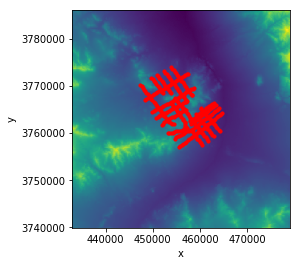

In [8]:

axs = plt.subplot()

mesh2D_base.plotImage(z_lin_base, ax=axs)

axs.scatter(rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], 10 ,'r')

# axs.set_xlim([local[0], local[2]])
# axs.set_ylim([local[1], local[3]])
axs.set_aspect('equal')

# Forward base correction

In [9]:
# surveylocal = Utils.io_utils.readUBCgravityObservations("FA_Local_378_New_ID.txt")
# Create a local survey
receivers = PF.BaseMag.RxObs(rxLoc[surveyId==1,:])
srcField = PF.BaseMag.SrcField([receivers], param=surveyFull.srcField.param)
survey_central = PF.BaseMag.LinearSurvey(srcField)
survey_central.dobs = surveyFull.dobs[surveyId==1]

nC = mesh2D_base.nC
activeCells = np.ones(nC, dtype='bool')
idenMap = Maps.IdentityMap(nP=nC)
# shutil.rmtree("./sensitivity.zarr")
prob = PF.Gravity.GravityIntegral(
    mesh2D_base, rhoMap=idenMap, 
    forwardOnly=True, actInd=activeCells
)

# Pair the survey and problem
#survey_local = surveyFull.dobs[surveyId==1]
survey_central.unpair()
survey_central.pair(prob)


prob.Zn = np.c_[np.zeros(nC), z_lin_base]

rho = 2.55
den = np.ones(mesh2D_base.nC) * rho
# den[mesh.gridCC[:, 2] < 40] = 0
# den[activeCells==0] = 0
correction_base = prob.fields(den[activeCells])

#Mesh.TreeMesh.writeUBC(
#       mesh, 'QuadtreeMeshGlobal.msh',
#       models={'Background_2p67gcc.den': den}
#     )

# Calculate corrected data
#survey_local = surveyFullN.dobs[surveyId==1]
d_corr_base = survey_central.dobs - correction_base

#d_corr1 = np.reshape(d_corr_base, [777, 1])
#res1 = np.subtract(d_corr1,  trend1)
#uncer = np.full((777,1), 0.03)
#res1 = np.c_[xobs[:, 0],yobs[:, 0], zobs[:, 0], res1[:, 0] ]
#cbog = np.c_[xobs[:, 0], yobs[:, 0], zobs[:, 0], d_corr1[:, 0] ]

#np.savetxt("Cbog_378_LN_Base.dat",d_corr_base)

#plt.savefig("Histogram_1_Quad_Tree_NN_180.png", dpi=300, bbox_inches='tight')
#rxLoc.shape, trend.shape, d_corr.shape
#res1.shape

Dask:
n_cpu:  8
n_chunks:  3
Chunk sizes:  126 87382
RAM/chunk:  0.088081056
Total RAM (x n_cpu):  0.704648448
[########################################] | 100% Completed | 51.6s


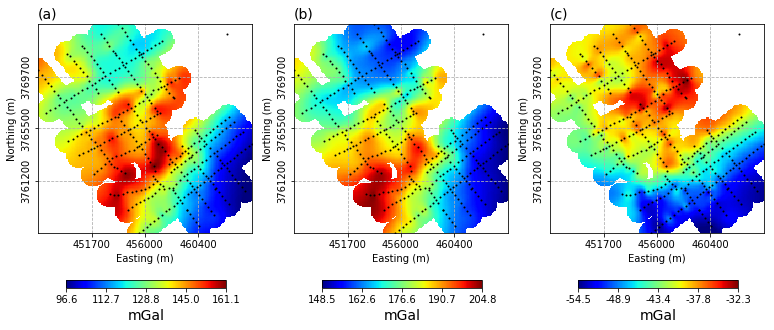

In [10]:
fig = plt.figure(figsize=(13,13))
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]


def plot_data(survey, d, axs, vmin=None, vmax=None, offsety=0.2,indexing='(a)'):
    if vmin is None:
        vmin = d.min()
    if vmax is None:
        vmax = d.max()
        
    out = Simulator.plotDataHillside(
        survey.rxLoc[:, 0], survey.rxLoc[:, 1], 
        d, 
        axs=axs, fill=True, contours=None,
        vmin=vmin, vmax=vmax, resolution=100,
        clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
        distMax=1000, azdeg=315, altdeg=45,
        equalizeHist=False, minCurvature=True,
        scatterData=None, shapeFile=None)
    axs.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
    axs.set_xticks(xlabel)
    axs.grid(True, linestyle='--')
    axs.set_xticklabels(xlabel)
    axs.set_yticks(ylabel)
    axs.set_yticklabels(ylabel, va='center', rotation=90)
    axs.set_ylabel("Northing (m)", rotation=90)
    axs.set_xlabel("Easting (m)", rotation=0)
    axs.set_aspect('equal')
#    axs.set_title('(a)', loc='left', size=14)
    
    pos = axs.get_position()
    axbar = plt.axes([pos.x0+.03, pos.y0-0.06,  pos.width*.75, pos.height*.3])
    cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
    cbar.set_ticks(np.linspace(vmin,vmax,5))
    cbar.set_label("mGal", size=14)
    axbar.axis('off')
    axs.set_title(indexing, loc='left', size=14)


d_plot = [survey_central.dobs, correction_base, d_corr_base]

indexing = ['(a)','(b)','(c)']
for ii, dd in enumerate(d_plot):

    ax = plt.subplot(1,3,ii+1)
    plot_data(survey_central, dd, ax,indexing=indexing[ii])
    
#plt.savefig("Fa_TopoCorr_Bog_Ln_base_jet.png", dpi=300, bbox_inches='tight')    

# Create 2D mesh for experiment and calculate 3 inteprolation for z values

In [15]:
meshutils.refine_tree_xyz?

In [16]:
core_cell_size = [90, 90]
padding_distance = [[5000, 5000], [5000, 5000], [5000, 0]]
octree_levels_topo = [0,0,0,12]
octree_levels_obs = [10]
octree_levels_padding = [10]
max_distance = 5000
depth_core = 5000

#........................................OR.......................
# Use Refine when want to add core_cell_size (Linear and MC)
mesh2D = meshutils.mesh_builder_xyz(
    topo[ind, :2], core_cell_size,
    padding_distance=padding_distance,
    mesh_type='TREE',
    depth_core=depth_core
    )

mesh2D = meshutils.refine_tree_xyz(
     mesh2D, rxLoc[surveyId==1, :2], method='surface',
     max_distance=max_distance,
     octree_levels=octree_levels_obs,
     octree_levels_padding=octree_levels_padding,
     finalize=True,
 )


# Linear
z_lin = F_lin(mesh2D.gridCC)### for Linear 

# for i in [z_lin[:]]: 
#     if  z_lin[np.isnan(z_lin)]:
#             z_lin = F(mesh2D.gridCC)
#                        z = topo[ind, 2]# iterate over rows

# Minimum curvature
F_MC = sp.interpolate.CloughTocher2DInterpolator(tri2D, topo[:, 2])# minimum Curvature
z_MC = F_MC(mesh2D.gridCC)

# for i in [z_MC[:]]: 
#     if  z_MC[np.isnan(z_MC)]:
#             z_MC = F(mesh2D.gridCC)
#                        z = topo[ind, 2]# iterate over rows
#...........................................................

# Nearest neighbour
# For z that are outside topo, assign nearest
tree = cKDTree(topo[:, :2])#  For all methods

r, indTree = tree.query(mesh2D.gridCC[:, :2])# last 2 means two nearest points
z_nn = topo[indTree, 2]# Use for nearest method
# for i in [z_nn[:]]: 
#     if  z_nn[np.isnan(z_nn)]:
#            z_nn = F(mesh2D.gridCC)
#                         z = topo[ind, 2]# iterate over rows

#............................................................
#np.savetxt("z_lin_360.dat", z_lin)
#np.savetxt("z_nn_360.dat", z_nn)
#np.savetxt("z_MC_360.dat", z_MC)

Text(0.5, 1.0, 'QuadTree_Mesh_Linear')

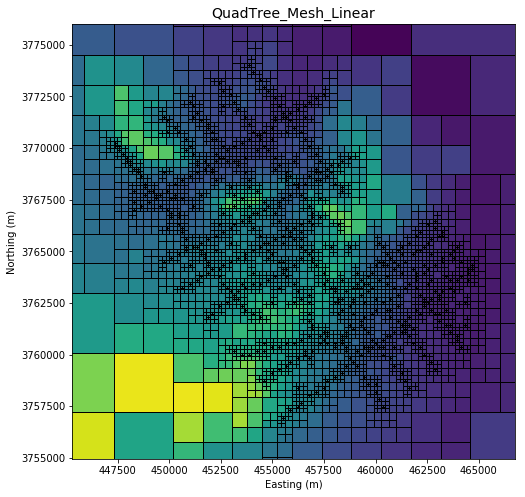

In [17]:
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
mesh2D.plotImage(z_lin, ax=ax1, grid=True, cmap='jet')
ax1.set_xlim([local[0]-2000, local[2]+2000])
ax1.set_ylim([local[1]-2000, local[3]+2000])

ax1.set_xlabel("Easting (m)", rotation=0)

ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
#ax1.set_title('(i)', loc='left', size=14)
ax1.set_title('QuadTree_Mesh_Linear', loc='center', size=14)

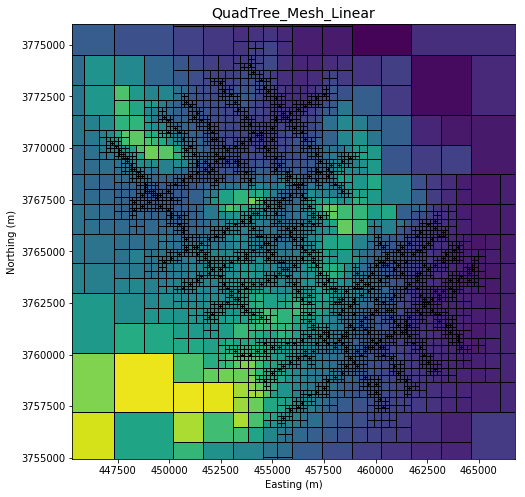

In [63]:
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
mesh2D.plotImage(z_lin, ax=ax1, grid=True, cmap='jet')
ax1.set_xlim([local[0]-2000, local[2]+2000])
ax1.set_ylim([local[1]-2000, local[3]+2000])

ax1.set_xlabel("Easting (m)", rotation=0)

ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
#ax1.set_title('(i)', loc='left', size=14)
ax1.set_title('QuadTree_Mesh_Linear', loc='center', size=14)

#ax1.set_title('(h)', loc='left', size=14)
#ax1.set_title('Topo_Corr_Ref-MC180', loc='center', size=14)

#ax2 = plt.subplot(1,1,1)
#mesh2D.plotImage(z_MC, ax=ax2, grid=True)
#ax2.set_xlim([local[0]-2000, local[2]+2000])
#ax2.set_ylim([local[1]-2000, local[3]+2000])
#ax2.set_aspect('equal')

#ax3 = plt.subplot(1,3,3)
#mesh2D.plotImage(z_nn, ax=ax3, grid=True)
#ax3.set_xlim([local[0]-2000, local[2]+2000])
#ax3.set_ylim([local[1]-2000, local[3]+2000])
#ax3.set_aspect('equal')
#plt.savefig("Mesh_Final_LN_Base.png", dpi=300, bbox_inches='tight')


In [12]:
z_nn, z_MC, z_lin


(array([1790., 1581., 1700., ..., 1361., 1554., 1939.]),
 array([1789.3996845 , 1579.54111433, 1715.5594532 , ..., 1361.59546248,
        1564.5883993 , 1932.24438194]),
 array([1792.88895455, 1579.76394934, 1718.65603808, ..., 1361.28169398,
        1564.65638263, 1929.64955383]))

# Create a forward linear

In [13]:
# Create the forward model operator

nC = mesh2D.nC
activeCells = np.ones(nC, dtype='bool')
idenMap = Maps.IdentityMap(nP=nC)

# shutil.rmtree("./sensitivity.zarr")
prob = PF.Gravity.GravityIntegral(
    mesh2D, rhoMap=idenMap, 
    forwardOnly=True, actInd=activeCells)

# Pair the survey and problem
survey_central.unpair()
survey_central.pair(prob)


prob.Zn = np.c_[np.zeros(nC), z_lin]

rho = 2.55
den = np.ones(mesh2D.nC) * rho
# den[mesh.gridCC[:, 2] < 40] = 0
# den[activeCells==0] = 0
correction_lin = prob.fields(den[activeCells])

#Mesh.TreeMesh.writeUBC(
#       mesh, 'QuadtreeMeshGlobal.msh',
#       models={'Background_2p67gcc.den': den}
#     )

# Calculate corrected data
d_corr_lin = survey_central.dobs - correction_lin

np.savetxt("correction_lin_360.dat", correction_lin)

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  378 5470
RAM/chunk:  0.016541280000000002
Total RAM (x n_cpu):  0.13233024000000002
[########################################] | 100% Completed |  1.8s


# Forward nearest neighbour

In [14]:
prob = PF.Gravity.GravityIntegral(
    mesh2D, rhoMap=idenMap, 
    forwardOnly=True, actInd=activeCells)

# Pair the survey and problem
survey_central.unpair()
survey_central.pair(prob)


prob.Zn = np.c_[np.zeros(nC), z_nn]

# rho = 2.55
# den = np.ones(mesh2D.nC) * rho
# den[mesh.gridCC[:, 2] < 40] = 0
# den[activeCells==0] = 0
correction_nn = prob.fields(den[activeCells])

#Mesh.TreeMesh.writeUBC(
#       mesh, 'QuadtreeMeshGlobal.msh',
#       models={'Background_2p67gcc.den': den}
#     )

# Calculate corrected data
d_corr_nn = survey_central.dobs - correction_nn
np.savetxt("correction_nn_360.dat", correction_nn)

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  378 5470
RAM/chunk:  0.016541280000000002
Total RAM (x n_cpu):  0.13233024000000002
[########################################] | 100% Completed |  2.2s


# Forward Minimum curvature

In [15]:
prob = PF.Gravity.GravityIntegral(
    mesh2D, rhoMap=idenMap, 
    forwardOnly=True, actInd=activeCells)
# Pair the survey and problem
survey_central.unpair()
survey_central.pair(prob)


prob.Zn = np.c_[np.zeros(nC), z_MC]

# rho = 2.55
# den = np.ones(mesh2D.nC) * rho
# den[mesh.gridCC[:, 2] < 40] = 0
# den[activeCells==0] = 0
correction_MC = prob.fields(den[activeCells])

#Mesh.TreeMesh.writeUBC(
#       mesh, 'QuadtreeMeshGlobal.msh',
#       models={'Background_2p67gcc.den': den}
#     )

# Calculate corrected data
d_corr_MC = survey_central.dobs - correction_MC
np.savetxt("correction_MC_360.dat", correction_MC)

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  378 5470
RAM/chunk:  0.016541280000000002
Total RAM (x n_cpu):  0.13233024000000002
[########################################] | 100% Completed |  2.4s


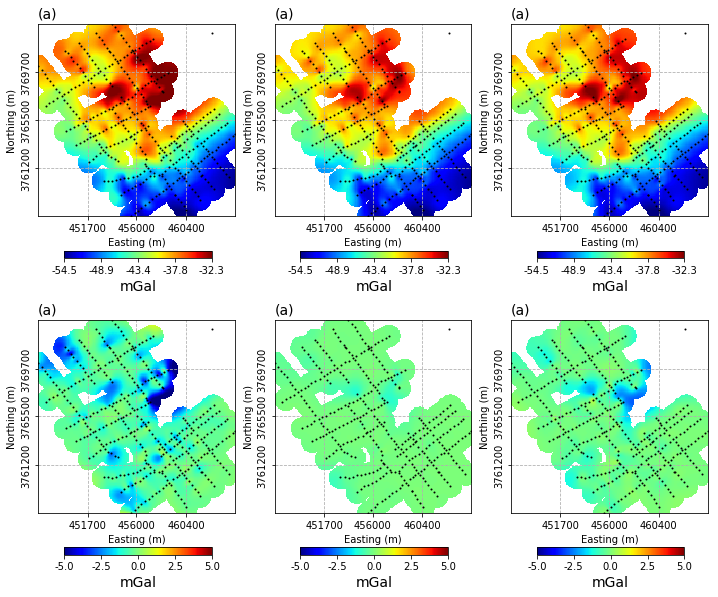

In [16]:
# Plotting the dufferent Terrain correction 
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]

fig = plt.figure(figsize=(12,10))

d_plot = [d_corr_nn, d_corr_lin, d_corr_MC]

for ii, dd in enumerate(d_plot):

    ax = plt.subplot(2,3,ii+1)
    plot_data(
        survey_central, dd, ax, 
        vmin=d_corr_base.min(), vmax=d_corr_base.max(), offsety=0.05
    )
    
    ax = plt.subplot(2,3,ii+4)
    plot_data(
        survey_central, d_corr_base - dd, ax,
        vmin=-5, vmax=5, offsety=0.05
    )


#plt.savefig("Bog_NN_LN_MC.png",dpi=300, bbox_inches='tight')

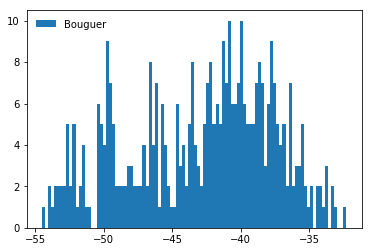

In [17]:
fig = plt.figure()
axs = plt.subplot()

out = axs.hist(d_corr_base, 100, label='Bouguer')
axs.legend(loc='upper left', frameon=False)

# Remove median background
x, y = rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1]
A = np.c_[np.ones_like(x), x, y]

# Compute least-squares solution for poly parameters
poly = np.linalg.solve(np.dot(A.T,A), np.dot(A.T, d_corr_base))

# Generate the first-order trend on each points
trend = np.dot(A,poly)#-125#np.mean(d_corr)#

#out = axs.hist(d_corr_base - trend, 100, label='Bouguer-trend1')
#axs.legend(loc='upper right', frameon=False)

#axs.set_title('Boguer & Detrended_Deg1_Bouguer')
trend1 = np.reshape(trend, [378, 1])
d_corr1 = np.reshape(d_corr_base, [378, 1])
res1 = np.subtract(d_corr1,  trend1)
uncer = np.full((378,1), 0.03)

#res1 = np.c_[rxLoc[surveyId==1, 0],rxLoc[surveyId==1, 1], rxLoc[surveyId==1, 2], res1[:, 0] ]
cbog = np.c_[rxLoc[surveyId==1, 0],rxLoc[surveyId==1, 1], rxLoc[surveyId==1, 2], d_corr1[:, 0], uncer[:, 0] ]

#cbog = np.c_[xobs[:, 0], yobs[:, 0], zobs[:, 0], d_corr1[:, 0] ]
#np.savetxt("res1_378_base.dat", res1)

np.savetxt("Cbog_378_base.dat",cbog)

plt.savefig("Histogram_Quad_Tree_Base.png", dpi=300, bbox_inches='tight')
#rxLoc.shape, trend.shape, d_corr.shape
#res1.shape

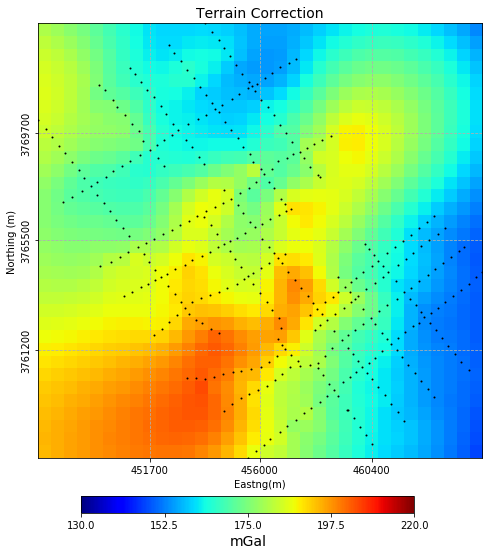

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,1,1)

xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminTopo, vmaxTopo = 1000, 3000
vminData, vmaxData = 130, 220
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], correction_base, 
    axs=ax1, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)


ax1.scatter(rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], 1, c='k', zorder=10)
#pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
#ax1.add_collection(pc)
ax1.grid(True, linestyle='--')
ax1.set_xlim(local[::2])
ax1.set_ylim(local[1::2])
ax1.set_xticks(xlabel)
ax1.set_xticklabels(xlabel)
ax1.set_yticks(ylabel)
ax1.set_yticklabels(ylabel, va='center', rotation=90)
ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_xlabel("Eastng(m)", rotation=0)

ax1.set_aspect('equal')
#ax1.set_title('(a)', loc='left', size=14)
ax1.set_title('Terrain Correction', loc='center', size=14)

pos = ax1.get_position()
axbar = plt.axes([pos.x0+.05, pos.y0-0.1,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')
correction1 = np.reshape(correction_base, [378, 1])
correctionR = np.c_[rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], rxLoc[surveyId==1, 2], correction1[:, 0]]
np.savetxt("terrain_corr_Base.dat", correctionR)
plt.savefig("Terrain_Corr_Base.png", dpi=300, bbox_inches='tight')


# Assessing the different types of Terrain Correction

# Plot the terrain corrected data 

# De-trending

## Method 1: Polynomial

Fit the local data with polynomial of different orders


## Method 2: Regional trend substraction

Calculate a trend from the regional data, substracted onto the local survey




In [19]:
# Bouguer anomalies d_corr in this code is already computed

# Compute 1th degree polynomial
x, y = rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1]
A = np.c_[np.ones_like(x), x, y]

# Compute least-squares solution for poly parameters
poly = np.linalg.solve(np.dot(A.T,A), np.dot(A.T, d_corr_base))

# Generate the first-order trend on each points
first = np.dot(A,poly)


# Compute 2th degree polynomial
A = np.c_[np.ones_like(x), x, y, x**2, x**2*y, x**2*y**2, y**2, x*y**2, x*y]

# Compute least-squares solution for poly parameters
poly = np.linalg.solve(np.dot(A.T,A), np.dot(A.T, d_corr_base))

# Generate the first-order trend on each points
second = np.dot(A,poly)


# Compute 3th degree polynomial
A = np.c_[np.ones_like(x), x, y, x**2, x**2*y, x**2*y**2, y**2, x*y**2, x*y, x**3, x**2*y, x*y**2, y**3]

# Compute least-squares solution for poly parameters
poly = np.linalg.solve(np.dot(A.T,A), np.dot(A.T, d_corr_base))

# Generate the first-order trend on each points
third = np.dot(A,poly)

z_centre = np.loadtxt("Cbog_378_base.dat")
z = z_centre[:, 2]
z_save = np.reshape(z, [378, 1])
x_save = np.reshape(x, [378, 1])
y_save = np.reshape(y, [378, 1])

third_save = d_corr_base - third
second_save = d_corr_base - second
first_save = d_corr_base - first

third_save = np.reshape(third_save, [378, 1])
uncer = np.full((378,1), 0.03)
third_save = np.c_[x_save[:, 0], y_save[:, 0], z_save[:, 0],  third_save[:, 0], uncer[:, 0]]
np.savetxt('Res_Deg3_378_base.dat', third_save)
second_save = np.reshape(second_save, [378, 1])
first_save = np.reshape(first_save, [378, 1])
second_save = np.c_[x_save[:, 0], y_save[:, 0], z_save[:, 0], second_save[:, 0], uncer[:, 0]]
first_save = np.c_[x_save[:, 0], y_save[:, 0], z_save[:, 0], first_save[:, 0], uncer[:, 0]]
np.savetxt('Res_Deg2_378_base.dat', second_save)
np.savetxt('Res_Deg1_378_base.dat', first_save)


In [20]:
# Compute minimum curvature trend from regional survey
locs, minCurv = MathUtils.minCurvatureInterp(
    rxLoc[surveyId==1, :2], d_corr_base, xyzOut=rxLoc[surveyId==1, :2]
)
mincur = d_corr_base - minCurv
minCurv_save = np.reshape(mincur, [378, 1])

mincurv_save = np.c_[rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 0], minCurv_save[:, 0], uncer[:,0]]
#np.savetxt('Res_From_Complete_378_Quad_Tree_NN20.dat', mincurv_save)

Cbog_Dom_379 = np.c_[rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], z_save[:, 0], d_corr_base, uncer[:, 0]]
#np.savetxt("Res_378_Min_Curv_Lat_Corr_Quad_Tree_NN20.dat", Cbog_Dom_379)


# Computing the Skewness 

In [21]:
from scipy.stats import skewtest
from scipy import stats

sk1 = skewtest(d_corr_base - first)
sk2 = skewtest(d_corr_base - second)
sk3 = skewtest(d_corr_base -third)
skc = skewtest(d_corr_base - minCurv)

mean1 = sp.mean(d_corr_base - first)
mean2 = sp.mean(d_corr_base - second)
mean3 = sp.mean(d_corr_base - third)
meanc = sp.mean(d_corr_base - minCurv)

med1 = np.median(d_corr_base - first)
med2 = np.median(d_corr_base - second)
med3 = np.median(d_corr_base - third)
medc = np.median(d_corr_base - minCurv)

print("skew1=", sk1, "skew2=", sk2, "skew3=", sk3, "skewC=", skc)
print("mean1=", mean1, "mean2=", mean2, "mean3=", mean3, "meanC=", meanc)
print("median1=", med1, "median2=", med2, "median3=", med3, "medianC=", medc)



#med12 = sc.stats.median_test(test[:4], test[4:])
#print(sk1, sk2, sk3, skminCurv)
#print( m1, m2, m3, mc)
#stats.median_absolute_deviation(first)



#print(med12)
#test[:4], test[4:]
first.shape

skew1= SkewtestResult(statistic=2.29943191378773, pvalue=0.021480425475970646) skew2= SkewtestResult(statistic=2.3447691157200197, pvalue=0.01903886525858498) skew3= SkewtestResult(statistic=3.2403109661070304, pvalue=0.001193994100709292) skewC= SkewtestResult(statistic=11.715524896128096, pvalue=1.0613187518633657e-31)
mean1= 5.828330175920017e-13 mean2= 7.70567513853397e-09 mean3= -3.3420773074337697e-09 meanC= 3.2735758372115333e-10
median1= -0.20199078224991496 median2= -0.15474226051809126 median3= -0.16012691121797218 medianC= 6.544792725549087e-07


(378,)

Text(0.0, 1.0, '(g)')

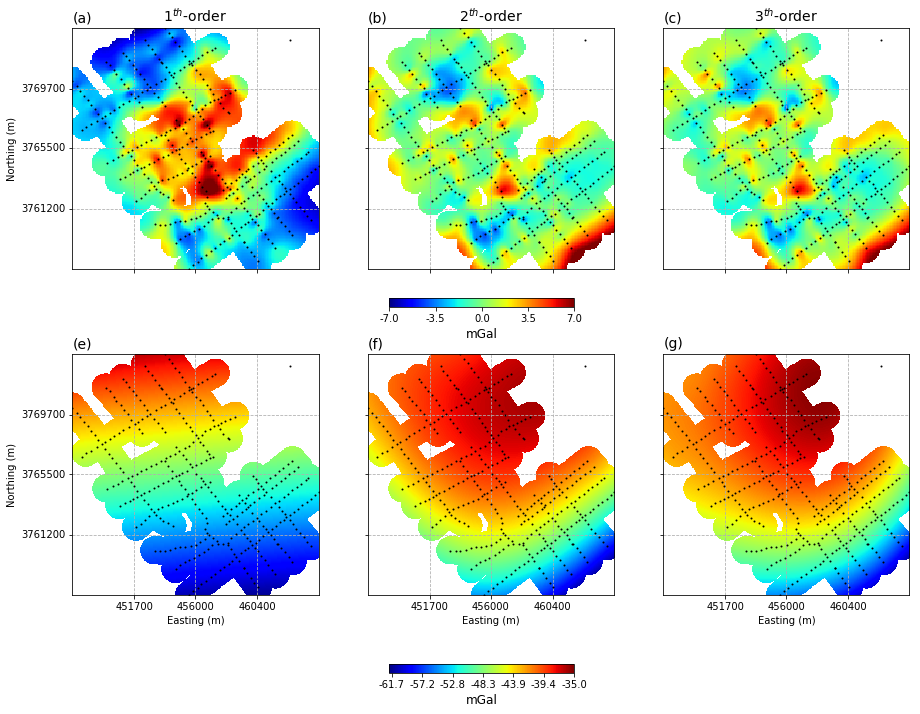

In [22]:
fig = plt.figure(figsize=(15,11))

ax3 = plt.subplot(2,3,1)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -7, 7
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], d_corr_base - first, 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels([])
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=0)
ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(a)', loc='left', size=14)
ax3.set_title('$1^{th}$-order', loc='center', size=14)

ax3 = plt.subplot(2,3,2)
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], d_corr_base - second, 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels([])
ax3.set_yticks(ylabel)
ax3.set_yticklabels([], va='center', rotation=90)
# ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(b)', loc='left', size=14)
ax3.set_title('$2^{th}$-order', loc='center', size=14)

pos = ax3.get_position()
axbar = plt.axes([pos.x0+.02, pos.y0-0.05,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=12)
axbar.axis('off')

ax3 = plt.subplot(2,3,3)
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], d_corr_base - third, 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels([])
ax3.set_yticks(ylabel)
ax3.set_yticklabels([], va='center', rotation=90)
ax3.set_aspect('equal')
ax3.set_title('(c)', loc='left', size=14)
ax3.set_title('$3^{th}$-order', loc='center', size=14)

#ax3 = plt.subplot(2,4,4)
#out = Simulator.plotDataHillside(
#    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], d_corr_base - minCurv, 
#    axs=ax3, fill=True, contours=None,
#    vmin=vminData, vmax=vmaxData, resolution=100,
#    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
#    distMax=1000, azdeg=315, altdeg=45,
#    equalizeHist=False, minCurvature=True,
#    scatterData=None, shapeFile=None)
#ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
#ax3.set_xticks(xlabel)
#ax3.grid(True, linestyle='--')
#ax3.set_xticklabels([])
#ax3.set_yticks(ylabel)
#ax3.set_yticklabels([], va='center', rotation=90)
#ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
#ax3.set_aspect('equal')
#ax3.set_title('(d)', loc='left', size=14)
#ax3.set_title('Regional', loc='center', size=14)

vminData, vmaxData = -75, -35

ax3 = plt.subplot(2,3,4)
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], first, 
    axs=ax3, fill=True, contours=None,
#    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=0)
ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(e)', loc='left', size=14)


ax3 = plt.subplot(2,3,5)
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], second, 
    axs=ax3, fill=True, contours=None,
#    vmin=vminData, vmax=vmaxData, resolution=200,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels([], va='center', rotation=90)
# ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(f)', loc='left', size=14)
# ax3.set_title('Second-order detrended', loc='center', size=14)

pos = ax3.get_position()
axbar = plt.axes([pos.x0+.02, pos.y0-0.1,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData, vmaxData, 10))
cbar.set_label("mGal", size=12)
axbar.axis('off')

ax3 = plt.subplot(2,3,6)
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], third, 
    axs=ax3, fill=True, contours=None,
#    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels([], va='center', rotation=90)
# ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(g)', loc='left', size=14)

#ax3 = plt.subplot(2,4,8)
#out = Simulator.plotDataHillside(
#    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], minCurv, 
#    axs=ax3, fill=True, contours=None,
#    vmin=vminData, vmax=vmaxData, resolution=100,
#    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
#    distMax=1000, azdeg=315, altdeg=45,
#    equalizeHist=False, minCurvature=True,
#    scatterData=None, shapeFile=None)
#ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
#ax3.set_xticks(xlabel)
#ax3.grid(True, linestyle='--')
#ax3.set_xticklabels(xlabel)
#ax3.set_yticks(ylabel)
#ax3.set_yticklabels([], va='center', rotation=90)
#ax3.set_ylabel("Northing (m)", rotation=90)
#ax3.set_xlabel("Easting (m)", rotation=0)
#ax3.set_aspect('equal')
#ax3.set_title('(h)', loc='left', size=14)

#pos = ax3.get_position()
#axbar = plt.axes([pos.x0+.125, pos.y0-0.1,  pos.width*.75, pos.height*.3])
#cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
#cbar.set_ticks(np.linspace(vminData, vmaxData, 5))
#cbar.set_label("mGal", size=14)
#axbar.axis('off')

#plt.savefig("DeTrends_Central_Base.png", dpi=300, bbox_inches='tight')

## Method 3: Scooping method

Invert the full dataset, reduce the local anomalies to zero, and forward model the regional signal

In [23]:
# Load the survey and mesh used in the inversion
surveyInv = Utils.io_utils.readUBCgravityObservations("Cbog_777_base_NN.txt")
mesh = Mesh.TreeMesh.readUBC("Grav_bogNN.msh")
den = Mesh.TreeMesh.readModelUBC(mesh, "Grav_bogNN.mod")
den[den==-100] = np.nan


In [24]:
grav = pv.PolyData(surveyInv.rxLoc)
# Add the data arrays
grav.point_arrays['comp-1'] = surveyInv.dobs

In [25]:
def plotVTKmodel(model):

    models = {"model":model}
    dataset = mesh.to_vtk(models)

    # Create display parameters for inverted model
    dparams = dict(
        show_edges=True,
        cmap='CMRmap_r',
        clim=[-0.01, .075],
    )

    # Apply a threshold filter to remove topography
    #  no arguments will remove the NaN values
    dataset.active_scalar_name = "model"
    dataset.cell_arrays['Active'] = ~np.isnan(model)

    # Extract volumetric threshold
    threshed = dataset.threshold(0.05, invert=False)
    slicer = dataset.threshold(0.05, invert=False, scalars='Active')

    # Create the rendering scene
    p = pv.Plotter(notebook=False)
    # add a grid axes
    p.show_grid()

    # Add spatially referenced data to the scene
    origin = threshed.center
    p.add_mesh(slicer.slice('x', np.r_[450210, origin[1], origin[2]]), **dparams)
    p.add_mesh(slicer.slice('y', np.r_[origin[0], 3770536, origin[2]]) , **dparams)
    p.add_mesh(slicer.slice('z', np.r_[origin[0], origin[1], -1000]) , **dparams)
    p.add_mesh(threshed, **dparams)
    # p.add_mesh(topo, opacity=0.75, color='grey',
    #            #cmap='gist_earth', clim=[1.7e+03, 3.104e+03],
    #            )
    p.add_mesh(grav, cmap='Spectral_r', point_size=5,
               render_points_as_spheres=True)

    # Here is a nice camera position we manually found:
    cpos = [(631577.7532352973, 3490682.636556013, 171423.18553407566),
     (458186.5, 3765165.0, -22939.0),
     (-0.2611423722769834, 0.44251534355537964, 0.8578955834596735)]
    p.camera_position = cpos

    p.show()

In [26]:
plotVTKmodel(den)


In [27]:
# Generate a problem
activeCells = ~np.isnan(den)
nC = int(activeCells.sum())
idenMap = Maps.IdentityMap(nP=nC)
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=activeCells,Jpath ="SimPEG_GRAV\\Tile0.zarr")

# Pair the survey and problem
surveyInv.unpair()
surveyInv.pair(prob)




In [28]:
# Check the predicted data
dpred = prob.fields(den[activeCells]).compute()


surveyFull = Utils.io_utils.readUBCgravityObservations("Cbog_777_base_NN_ID.txt")

rxLoc = surveyFull.rxLoc
surveyId = surveyFull.std
local = np.r_[rxLoc[surveyId>0,:2].min(axis=0), rxLoc[surveyId>0,:2].max(axis=0)]
regio = np.r_[rxLoc[:,:2].min(axis=0), rxLoc[:,:2].max(axis=0)]
rec = Rectangle(local[:2], local[2]-local[0], local[3]-local[1])

Dask:
n_cpu:  8
n_chunks:  2
Chunk sizes:  389 26408
RAM/chunk:  0.082181696
Total RAM (x n_cpu):  0.657453568
Zarr file detected with same shape and chunksize ... re-loading


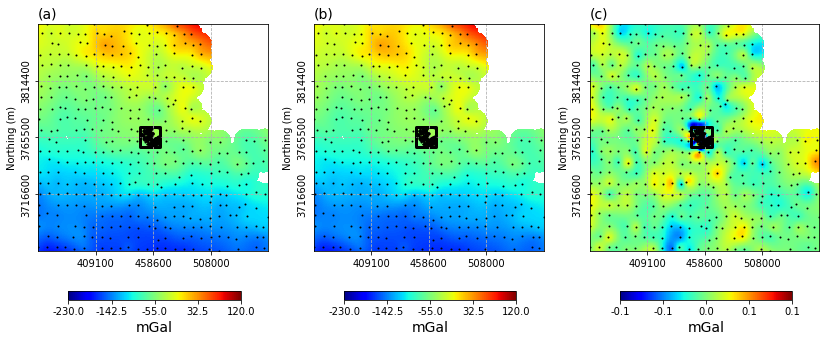

In [29]:
fig = plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,3,1)

xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(regio[0], regio[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(regio[1], regio[3],5)[1:4].tolist()]

vminTopo, vmaxTopo = 1000, 3000
vminData, vmaxData = -230, 120
out = Simulator.plotDataHillside(
    rxLoc[:, 0], rxLoc[:, 1], surveyInv.dobs, 
    axs=ax1, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)

ax1.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax1.add_collection(pc)
ax1.grid(True, linestyle='--')
ax1.set_xlim(regio[::2])
ax1.set_ylim(regio[1::2])
ax1.set_xticks(xlabel)
ax1.set_xticklabels(xlabel)
ax1.set_yticks(ylabel)
ax1.set_yticklabels(ylabel, va='center', rotation=90)
ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
ax1.set_title('(a)', loc='left', size=14)

pos = ax1.get_position()
axbar = plt.axes([pos.x0+.03, pos.y0-0.1,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')

ax1 = plt.subplot(1,3,2)
vminTopo, vmaxTopo = 1000, 3000
vminData, vmaxData = -230, 120
out = Simulator.plotDataHillside(
    rxLoc[:, 0], rxLoc[:, 1], dpred, 
    axs=ax1, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)

ax1.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax1.add_collection(pc)
ax1.grid(True, linestyle='--')
ax1.set_xlim(regio[::2])
ax1.set_ylim(regio[1::2])
ax1.set_xticks(xlabel)
ax1.set_xticklabels(xlabel)
ax1.set_yticks(ylabel)
ax1.set_yticklabels(ylabel, va='center', rotation=90)
ax1.set_ylabel("Northing (m)", rotation=90)
ax1.set_aspect('equal')
ax1.set_title('(b)', loc='left', size=14)

pos = ax1.get_position()
axbar = plt.axes([pos.x0+.03, pos.y0-0.1,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')

ax3 = plt.subplot(1,3,3)
vminTopo, vmaxTopo = 1000, 3000
vminData, vmaxData = -0.1, 0.1
out = Simulator.plotDataHillside(
    rxLoc[:, 0], rxLoc[:, 1], surveyInv.dobs - dpred, 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=500,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=10000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)

ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
pc = PatchCollection([rec], facecolor='none', edgecolor='k', linewidth=3)
ax3.add_collection(pc)
ax3.grid(True, linestyle='--')
ax3.set_xlim(regio[::2])
ax3.set_ylim(regio[1::2])
ax3.set_xticks(xlabel)
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_aspect('equal')
ax3.set_title('(c)', loc='left', size=14)

pos = ax3.get_position()
axbar = plt.axes([pos.x0+.03, pos.y0-0.1,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')


plt.savefig("Mahallat_RegionalPredicted_bogNN100.png", dpi=300, bbox_inches='tight')



In [30]:
# Zero out core
den_Scooped = den.copy()
# den_Scooped[(mesh.gridCC[:, 2]>-9000) * (mesh.gridCC[:, 0]>442000) * (mesh.gridCC[:, 0]<468000)* (mesh.gridCC[:, 1]>3752000) * (mesh.gridCC[:, 1]<3781000)] = 0
den_Scooped[(mesh.gridCC[:, 2]>-9000) * (mesh.gridCC[:, 0]>local[0]-2000) * (mesh.gridCC[:, 0]<local[2]+2000)* (mesh.gridCC[:, 1]>local[1]-2000) * (mesh.gridCC[:, 1]<local[3]+2000)] = 0

# den_Scooped[~activeCells] = np.nan


In [31]:
plotVTKmodel(den_Scooped)

In [32]:
# Forward the scooped model (Regional effect)
d_scoop = prob.fields(den_Scooped[activeCells]).compute()

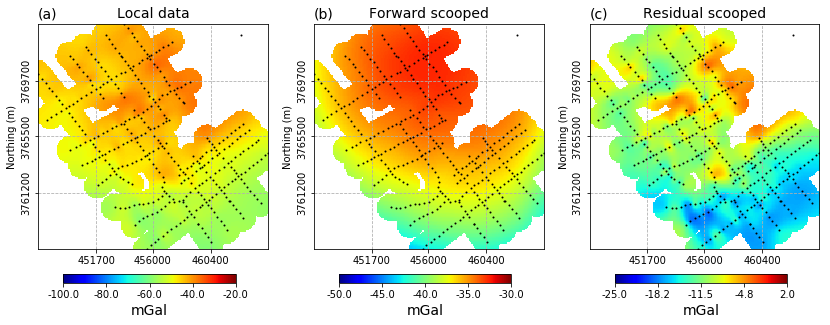

In [33]:


fig = plt.figure(figsize=(14,7))

ax3 = plt.subplot(1,3,1)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -100,-20
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], surveyInv.dobs[surveyId==1], 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(a)', loc='left', size=14)
ax3.set_title('Local data', loc='center', size=14)
pos = ax3.get_position()
axbar = plt.axes([pos.x0+.025, pos.y0-0.07,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')


ax3 = plt.subplot(1,3,2)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -50, -30
out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], d_scoop[surveyId==1], 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(b)', loc='left', size=14)
ax3.set_title('Forward scooped', loc='center', size=14)
pos = ax3.get_position()
axbar = plt.axes([pos.x0+.025, pos.y0-0.07,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')

ax3 = plt.subplot(1,3,3)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -25, 2
#vminData, vmaxData = 0, 20

out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1], 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=100,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1000, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
# ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
ax3.set_title('(c)', loc='left', size=14)
ax3.set_title('Residual scooped', loc='center', size=14)
pos = ax3.get_position()
axbar = plt.axes([pos.x0+.025, pos.y0-0.07,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')
plt.savefig("Scooping_Residual_NN100.png", dpi=300, bbox_inches='tight')
#d_scoop[surveyId==1].shape

(0.0, 1.0, 0.0, 1.0)

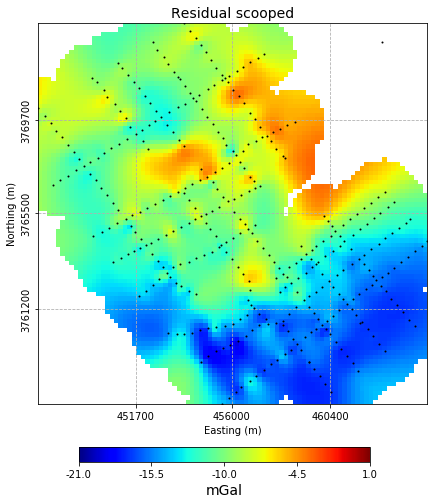

In [34]:
fig = plt.figure(figsize=(14,7))

ax3 = plt.subplot(1,1,1)
xlabel = [int(np.round(xx/100)*100) for xx in np.linspace(local[0], local[2],5)[1:4].tolist()]
ylabel = [int(np.round(yy/100)*100) for yy in np.linspace(local[1], local[3],5)[1:4].tolist()]
vminData, vmaxData = -21, 1
#vminData, vmaxData = 0, 20

out = Simulator.plotDataHillside(
    rxLoc[surveyId==1, 0], rxLoc[surveyId==1, 1], surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1], 
    axs=ax3, fill=True, contours=None,
    vmin=vminData, vmax=vmaxData, resolution=200,
    clabel=True, cmap='jet', ve=1., alpha=1., alphaHS=0.,
    distMax=1500, azdeg=315, altdeg=45,
    equalizeHist=False, minCurvature=True,
    scatterData=None, shapeFile=None)
ax3.scatter(rxLoc[:, 0], rxLoc[:, 1], 1, c='k', zorder=10)
ax3.set_xticks(xlabel)
ax3.grid(True, linestyle='--')
ax3.set_xticklabels(xlabel)
ax3.set_yticks(ylabel)
ax3.set_yticklabels(ylabel, va='center', rotation=90)
ax3.set_ylabel("Northing (m)", rotation=90)
ax3.set_xlabel("Easting (m)", rotation=0)
ax3.set_aspect('equal')
#ax3.set_title('(c)', loc='left', size=14)
ax3.set_title('Residual scooped', loc='center', size=14)
pos = ax3.get_position()
axbar = plt.axes([pos.x0+.04, pos.y0-0.12,  pos.width*.75, pos.height*.3])
cbar = plt.colorbar(out[3], orientation='horizontal',format='%.1f')
cbar.set_ticks(np.linspace(vminData,vmaxData,5))
cbar.set_label("mGal", size=14)
axbar.axis('off')


#plt.savefig("Scooping_Residual_octree_23.png", dpi=300, bbox_inches='tight')
#d_scoop[surveyId==1].shape

In [35]:
newz = surveyFull.srcField.rxList[0].locs[surveyId==1, 2] + 50
d_central = surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1]

xyzdu = np.c_[surveyFull.rxLoc[surveyId==1, :2], newz, d_central, np.ones_like(d_central)]
np.savetxt("Res_Scooped_NN100.dat", xyzdu)
# Utils.io_utils.writeUBCgravityObservations("FA_Central_Scooped.dat", surveyFull, d_corr)

In [36]:


surveyCentral = Utils.io_utils.readUBCgravityObservations("Res_Central_Scooped_octree.dat")

r, ind = tree.query(surveyCentral.rxLoc[:, :2])
z = topo[ind, 2]
surveyCentral.srcField.rxList[0].locs[:, 2] = z + 100 
Utils.io_utils.writeUBCgravityObservations("Res_Central_Scooped_up100m_octree.dat", surveyCentral, surveyCentral.dobs)

Observation file saved to: Res_Central_Scooped_up100m_octree.dat


In [37]:
skScoo = skewtest(surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1])
meanScoo = sp.mean(surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1])

medScoo = np.median(surveyInv.dobs[surveyId==1]-d_scoop[surveyId==1])
print(skScoo, meanScoo, medScoo)

SkewtestResult(statistic=-0.26408602391372166, pvalue=0.7917136330228404) -11.597100634297627 -11.260145830994372


# Distributions Histograms

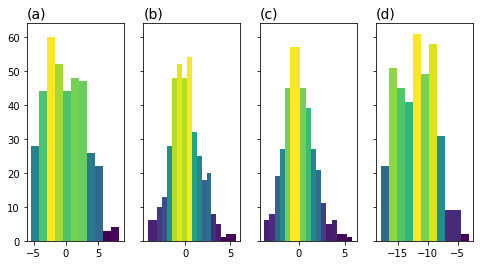

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
N_points = 1000
n_bins = 40

scoop = np.loadtxt("Res_Central_Scooped_octree.dat", skiprows=1)
scoop_dat = scoop[:, 3] 

fig, axs = plt.subplots(1,4, figsize=(8, 4),sharey=True, tight_layout= False)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(d_corr_base - first, bins='auto')

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
axs[0].set_title('(a)', loc='left', size=14)


N, bins, patches = axs[1].hist(d_corr_base - second, bins='auto')
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
axs[1].set_title('(b)', loc='left', size=14)

    
N, bins, patches = axs[2].hist(d_corr_base - third, bins='auto')
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[2].set_title('(c)', loc='left', size=14)

    
#N, bins, patches = axs[3].hist(d_corr[surveyId==1] - minCurv, bins='auto')
#fracs = N / N.max()
#norm = colors.Normalize(fracs.min(), fracs.max())
#for thisfrac, thispatch in zip(fracs, patches):
#    color = plt.cm.viridis(norm(thisfrac))
#    thispatch.set_facecolor(color)
#axs[3].set_title('(d)', loc='left', size=14)


N, bins, patches = axs[3].hist(scoop_dat, bins='auto')
axs[3].set_title('(d)', loc='left', size=14)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
#axs[4].xaxis.set_major_formatter(FixedFormatter)

plt.savefig("Histograms__Quad_Tree_Final.png", dpi=300, bbox_inches='tight')  

# Probability Plots

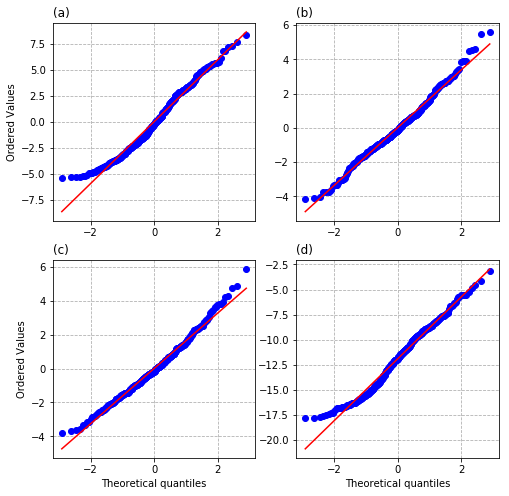

In [41]:
from scipy import stats
fig, ax = plt.subplots(1,4, figsize=(8, 8))

ax1 = plt.subplot(221)
#x = stats.t.rvs(3, size=nsample)
x1 = d_corr_base - first
res1 = stats.probplot(x1, plot=plt)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
ax1.grid(True, linestyle='--')
ax1.set_xlabel('')
ax1.set_title('')
ax1.set_title('(a)', loc='left', size=12)

ax2 = plt.subplot(222)
#x = stats.t.rvs(25, size=nsample)
x2 = d_corr_base - second
res2 = stats.probplot(x2, plot=plt)
ax2.grid(True, linestyle='--')
#ax2.set_xticks([])
#ax2.set_xticklabels([])
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_yticks([])
#ax2.set_yticklabels('')
ax2.set_title('')
ax2.set_title('(b)', loc='left', size=12)

ax3 = plt.subplot(223)
#x = stats.t.rvs(25, size=nsample)
x3 = d_corr_base - third
res3 = stats.probplot(x3, plot=plt)
ax3.grid(True, linestyle='--')
ax3.set_title('')
ax3.set_title('(c)', loc='left', size=12)

ax4 = plt.subplot(224)
#x = stats.t.rvs(25, size=nsample)
x4 = scoop_dat
res2 = stats.probplot(x4, plot=plt)
ax4.grid(True, linestyle='--')
#ax2.set_xticks([])
#ax2.set_xticklabels([])
#ax2.set_xlabel('')
ax4.set_ylabel('')
#ax4.set_yticks([])
#ax4.set_yticklabels('')
ax4.set_title('')

ax4.set_title('')
ax4.set_title('(d)', loc='left', size=12)
#ax4.legend('P')
#plt.show()

plt.savefig("Prob_Plots_Res.png", dpi=300, bbox_inches='tight')  